## For random testing 

In [29]:
import pandas as pd
import numpy as np
import os

import sklearn.model_selection as cv
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib

from keras.models import Sequential, save_model, load_model
from keras.layers import Dense, Input
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import keras.backend as K

In [30]:
df = pd.read_csv("data.csv", index_col=0)
df = df.reset_index(drop=True)
#df

In [31]:
df_online = df[df["online_batch"] == 1]
df_offline = df[df["online_batch"] == 0]
#del df_online["online_batch"],df_offline["online_batch"]

In [72]:
# To take equal samples of both
df_online_joining = df_online[(df_online["joining_result"] == 1)]
df_online_not_joining = df_online[(df_online["joining_result"] == 0)].head(df_online_joining.shape[0])
df_online = pd.concat([df_online_joining,df_online_not_joining])

df_offline_joining = df_offline[(df_offline["joining_result"] == 1)]
df_offline_not_joining = df_offline[(df_offline["joining_result"] == 0)].head(df_offline_joining.shape[0])
df_offline = pd.concat([df_offline_joining,df_offline_not_joining])

df = pd.concat([df_online,df_offline])
df = shuffle(df)
df.reset_index(drop=True,inplace=True)
#df

In [73]:
# (df["joining_result"] == 1).sum(), (df["joining_result"] == 0).sum()

In [74]:
X = df.iloc[:,:-1].values
Y = df.iloc[:,-1].values
X.shape,Y.shape

((1892, 13), (1892,))

In [75]:
# set(X[:,2])

In [76]:
oneHotEncoder1= OneHotEncoder(n_values=[5,10],categorical_features = [2,X.shape[1]-1])
X = oneHotEncoder1.fit_transform(X).toarray()
X.shape,Y.shape

((1892, 26), (1892,))

In [77]:
# cols = [i for i in range(X.shape[1])]
# cols.remove(0)
# cols.remove(5)
# X = X[:,cols]
# X.shape

In [78]:
# set(X[:,X.shape[1]-1])

In [141]:
X_train, X_test, Y_train, Y_test = cv.train_test_split(X,Y,test_size=0.2,random_state=0)

In [142]:
# print(Y_train.sum(), (Y_train == 0).sum(), Y_test.sum(), (Y_test == 0).sum())

In [143]:
scaler = StandardScaler().fit(X_train)
X_scaled_train = scaler.transform(X_train)
X_scaled_test = scaler.transform(X_test)

In [144]:
model = Sequential()
model.add(Dense(20, input_shape=(X.shape[1],) ,activation='relu'))
model.add(Dense(30, activation='sigmoid'))
model.add(Dense(40, activation='sigmoid'))
model.add(Dense(40, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(20, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
class_weight = {0: 0.5, 1: 0.5}
model.fit(X_scaled_train,Y_train,epochs=50,batch_size=10,class_weight=class_weight,validation_data=(X_scaled_test,Y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_101 (Dense)            (None, 20)                540       
_________________________________________________________________
dense_102 (Dense)            (None, 30)                630       
_________________________________________________________________
dense_103 (Dense)            (None, 40)                1240      
_________________________________________________________________
dense_104 (Dense)            (None, 40)                1640      
_________________________________________________________________
dense_105 (Dense)            (None, 30)                1230      
_________________________________________________________________
dense_106 (Dense)            (None, 20)                620       
_________________________________________________________________
dense_107 (Dense)            (None, 1)                 21        
Total para

In [145]:
directory = "/home/aakash/Drive/Dropbox/ML/Aakash"

In [146]:
oneHotEncoder1 = joblib.load(os.path.join(directory, 'oneHotEncoder.pkl'))
scaler = joblib.load(os.path.join(directory, 'scaler.pkl'))
model = load_model(os.path.join(directory, 'model.h5'))

In [147]:
# def model():
#     model = Sequential()
#     model.add(Dense(20, input_dim=26))
#     model.add(Dense(30, activation='sigmoid'))
#     model.add(Dense(40, activation='sigmoid'))
#     model.add(Dense(40, activation='relu'))
#     model.add(Dense(30, activation='relu'))
#     model.add(Dense(20, activation='sigmoid'))
#     model.add(Dense(1, activation='sigmoid'))

#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#     return model

# pipe = Pipeline([('oneHotEncoder', OneHotEncoder(n_values=[5,10],categorical_features = [2,12])),
#                      ('scaler',StandardScaler(with_mean=False)), 
#                      ('nn', KerasClassifier(build_fn=model, epochs=40, batch_size=5))
#                     ])

In [148]:
# features = df.columns.tolist()
# result = features.pop()
# X = df[features]
# Y = df[result]
# X_train, X_test, Y_train, Y_test = cv.train_test_split(X.values,Y.values,test_size=0.2,random_state=0)

In [149]:
# pipe.fit(X_train,Y_train)

In [150]:
# directory = "/home/aakash/Drive/Dropbox/ML/Aakash"
# model_step = pipe.steps.pop(-1)[1]

In [151]:
# joblib.dump(pipe, os.path.join(directory, 'pipeline.pkl'))
# save_model(model_step.model, os.path.join(directory, 'model.h5'))

In [152]:
# K.clear_session()
# pipe = joblib.load(os.path.join(directory, 'pipeline.pkl'))
# model = load_model(directory + '/model.h5')
# pipe.steps.append(('nn', model))

In [153]:
y_pred = model.predict(X_scaled_test)
y_pred_train = model.predict(X_scaled_train)

In [154]:
y_pred_rounded = np.round(y_pred)
y_pred_rounded_train = np.round(y_pred_train)

In [155]:
print(classification_report(Y_test,y_pred_rounded))
print(confusion_matrix(Y_test,y_pred_rounded))

print(classification_report(Y_train,y_pred_rounded_train))
print(confusion_matrix(Y_train,y_pred_rounded_train))

             precision    recall  f1-score   support

          0       0.60      0.74      0.67       180
          1       0.71      0.56      0.62       199

avg / total       0.66      0.65      0.64       379

[[134  46]
 [ 88 111]]
             precision    recall  f1-score   support

          0       0.74      0.86      0.80       766
          1       0.83      0.69      0.75       747

avg / total       0.78      0.78      0.77      1513

[[660 106]
 [232 515]]


In [156]:
#Trying to variate the threshold value
threshold = 0.47
rounded = np.zeros(y_pred.shape)
for i in range(y_pred.shape[0]):
    rounded[i][0] = (y_pred[i][0] >= threshold)
print(classification_report(Y_test,rounded))
print(confusion_matrix(Y_test,rounded))

             precision    recall  f1-score   support

          0       0.62      0.71      0.66       180
          1       0.70      0.61      0.65       199

avg / total       0.66      0.66      0.66       379

[[128  52]
 [ 78 121]]


In [157]:
count = 0
lower_limit = 0.3
upper_limit = 0.7
for i in range(y_pred.shape[0]):
    if ((y_pred[i][0] >= lower_limit) & (y_pred[i][0] <= upper_limit)):
        count += 1 
print("Percentage of samples lying in this range = ", count*100/y_pred.shape[0])

Percentage of samples lying in this range =  27.70448548812665


In [158]:
ranges = [round(0.1*i,1) for i in range(0,11)]
joining_results = []
not_joining_results = []
for i in range(1,11):
    lower_limit = ranges[i-1]
    upper_limit = ranges[i]
    joining = 0
    not_joining = 0
    for j in range(y_pred.shape[0]):
        if((y_pred[j][0] >= lower_limit) & (y_pred[j][0] < upper_limit)):
            if(Y_test[j] == 1):
                joining += 1
            else:
                not_joining += 1
    joining_results.append(joining)
    not_joining_results.append(not_joining)

In [159]:
print(joining_results)
print(not_joining_results)

[12, 9, 31, 14, 22, 11, 13, 12, 12, 63]
[36, 43, 31, 11, 13, 9, 12, 14, 3, 8]


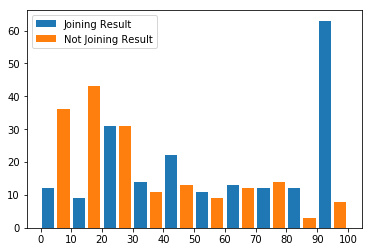

In [160]:
import matplotlib.pyplot as plt
joining_pos = [ i*10 + 2.5 for i in range(0,10)]
not_joining_pos = [ i*10 + 7.5 for i in range(0,10)]
plt.bar(joining_pos,joining_results,width=4, label="Joining Result")
plt.bar(not_joining_pos,not_joining_results,width=4, label="Not Joining Result")
plt.xticks([10*i for i in range(0,11)])
plt.legend()
plt.show()